<a href="https://colab.research.google.com/github/weiyunna/Deep-Learning-with-Tensorflow/blob/master/Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to Word Embedding

This tutorial introduces word embeddings. It contains complete code to train word embeddings from scratch on a small dataset, and to visualize these embeddings using the** Embedding Projector** (shown in the image below).

## Represent text as numbers

Machine learning models take vectors (arrays of numbers) as input. When working with text, the first thing we must do come up with a strategy to convert strings to numbers (or to "**vectorize**" the text) before feeding it to the model. In this section, we will look at three strategies for doing so.

### One-hot encodings

As a first idea, we might "one-hot" encode each word in our vocabulary. Consider the sentence "The cat sat on the mat". The vocabulary (or unique words) in this sentence is (cat, mat, on, sat, the). To represent each word, we will create a zero vector with `length equal to the vocabulary`, then place a one in the index that corresponds to the word. This approach is shown in the following diagram.

To create a vector that contains the encoding of the sentence, we could then concatenate the one-hot vectors for each word.

Key point: This approach is inefficient. A one-hot encoded vector is **sparse** (meaning, most indicices are zero). Imagine we have 10,000 words in the vocabulary. To one-hot encode each word, we would create a vector where 99.99% of the elements are zero.

### Encode each word with a unique number

A second approach we might try is to encode each word using a unique number. Continuing the example above, we could assign 1 to "cat", 2 to "mat", and so on. We could then encode the sentence "The cat sat on the mat" as a dense vector like [5, 1, 4, 3, 5, 2]. This appoach is efficient. Instead of a sparse vector, we now have a dense one (where all elements are full).

There are two downsides to this approach, however:

* The integer-encoding is arbitrary (it does not capture any relationship between words).

* An integer-encoding can be challenging for a model to interpret. A linear classifier, for example, learns a single weight for each feature. Because different words may have a similar encoding, this feature-weight combination is not meaningful.

### Word embeddings

Word embeddings give us a way to use an efficient, dense representation in which **similar words have a similar encoding**. 

Importantly, we do not have to specify this encoding by hand. 

An embedding is **a dense vector of floating point values ** (the length of the vector is a parameter you specify). 

Instead of specifying the values for the embedding manually, they are **trainable parameters** (weights learned by the model during training, in the same way a model learns weights for a dense layer). 

It is common to see word embeddings that **8-dimensional** (for small datasets), up to **1024-dimensions **when working with large datasets. 

A higher dimensional embedding can capture fine-grained relationships between words, but takes more data to learn.

Above is a diagram for a word embedding. 

Each word is represented as a 4-dimensional vector of floating point values. 

Another way to think of an embedding is as **"lookup table"**. 

After these weights have been learned, we can encode each word by looking up the dense vector it corresponds to in the table.

## Using the Embedding layer

Keras makes it easy to use word embeddings. Let's take a look at the **Embedding** layer.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# The Embedding layer takes at least two arguments:
# the number of possible words in the vocabulary, here 1000 (1 + maximum word index),
# and the dimensionality of the embeddings, here 32.
embedding_layer = layers.Embedding(1000, 32)

    100% |████████████████████████████████| 79.9MB 299kB/s 
    100% |████████████████████████████████| 3.0MB 8.6MB/s 
    100% |████████████████████████████████| 419kB 15.7MB/s 
    100% |████████████████████████████████| 61kB 23.0MB/s 


The Embedding layer can be understood as a lookup table that maps from integer indices (which stand for specific words) to dense vectors (their embeddings). 

The dimensionality (or width) of the embedding is a parameter you can experiment with to see what works well for your problem, much in the same way you would experiment with the number of neurons in a Dense layer.

When you create an Embedding layer, the weights for the embedding are randomly initialized (just like any other layer). 

During training, they are gradually adjusted via backpropagation. Once trained, the learned word embeddings will roughly encode **similarities** between words (as they were learned for the specific problem your model is trained on).

As **input**, the Embedding layer takes a 2D tensor of integers, of shape (samples, sequence_length), where each entry is a sequence of integers. 

It can embed sequences of variable lengths. You could feed into the embedding layer above batches with shapes (32, 10) (batch of 32 sequences of length 10) or (64, 15) (batch of 64 sequences of length 15).

All sequences in a batch must have the same length, so sequences that are shorter than others should be **padded** with zeros, and sequences that are longer should be **truncated**.

As output, the embedding layer returns a **3D** floating point tensor, of shape (**samples, sequence_length, embedding_dimensionality**). 

Such a 3D tensor can then be processed by a RNN layer, or can simply be flattened or pooled and processed by a Dense layer. We will show the first approach in this tutorial, and you can refer to the Text Classification with an RNN to learn the second.

## Learning Embeddings from Scratch

We will train a sentiment classifier on IMDB movie reviews. 

In the process, we will learn embeddings from scratch. 

We will move quickly through the code that downloads and preprocesses the dataset (see this tutorial for more details).

In [2]:
vocab_size = 10000
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=vocab_size)

17465344/17464789 [==============================] - 3s 0us/step


As imported, the text of reviews is integer-encoded (each integer represents a specific word in a dictionary).

In [3]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


### Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query **a dictionary object that contains the integer to string mapping:**

In [4]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_review(train_data[0])

1646592/1641221 [==============================] - 0s 0us/step


"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [0]:
word_index
reverse_word_index

Movie reviews can be different lengths. We will use the **pad_sequences ** function to standardize the lengths of the reviews.

In [0]:
maxlen = 500

train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=maxlen)

In [0]:
# Let's inspect the first padded review.

print(train_data[0])

##Create a simple model

We will use the Keras Sequential API to define our model.

* The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. **The resulting dimensions are: (batch, sequence, embedding)`.**

* Next, a **GlobalAveragePooling1D** layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

* This fixed-length output vector is piped through a **fully-connected (Dense)** layer with 16 hidden units.

* The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a **probability** (or confidence level) that the review is positive.

In [9]:
embedding_dim=16

model = keras.Sequential([
  layers.Embedding(vocab_size, embedding_dim, input_length=maxlen),
  layers.GlobalAveragePooling1D(),
  layers.Dense(16, activation='relu'),
  layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [10]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_data,
    train_labels,
    epochs=30,
    batch_size=512,
    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 2s 111us/sample - loss: 0.6927 - accuracy: 0.5207 - val_loss: 0.6920 - val_accuracy: 0.5654
Epoch 2/30
20000/20000 [==============================] - 2s 93us/sample - loss: 0.6908 - accuracy: 0.6351 - val_loss: 0.6889 - val_accuracy: 0.5826
Epoch 3/30
20000/20000 [==============================] - 2s 95us/sample - loss: 0.6864 - accuracy: 0.6606 - val_loss: 0.6823 - val_accuracy: 0.7256
Epoch 4/30
20000/20000 [==============================] - 2s 98us/sample - loss: 0.6770 - accuracy: 0.7405 - val_loss: 0.6688 - val_accuracy: 0.7284
Epoch 5/30
20000/20000 [==============================] - 2s 100us/sample - loss: 0.6595 - accuracy: 0.7645 - val_loss: 0.6463 - val_accuracy: 0.7784
Epoch 6/30
20000/20000 [==============================] - 2s 101us/sample - loss: 0.6314 - accuracy: 0.7903 - val_loss: 0.6136 - val_accuracy: 0.7868
Epoch 7/30
20000/20000 [==============================

With this approach our model reaches a validation accuracy of around 88% (note the model is overfitting, training accuracy is significantly higher).

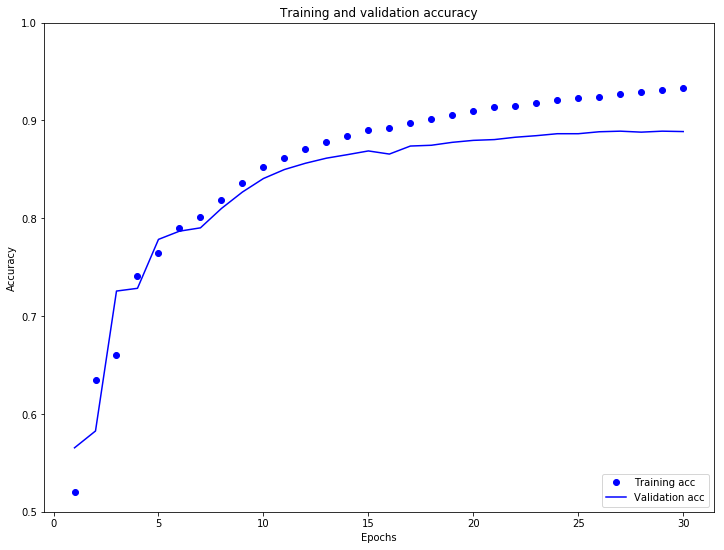

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim((0.5,1))

plt.show()

## Retrieve the Learned Embeddings

Next, let's retrieve the word embeddings learned during training. This will be a matrix of shape (**vocab_size,embedding-dimension**).

In [12]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


We will now write the weights to disk. To use the Embedding Projector, we will upload two files in tab separated format: a file of vectors (**containing the embedding**), and a file of meta data (**containing the words**).

In [0]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(vocab_size):
  word = reverse_word_index[word_num]
  embeddings = weights[word_num]
  out_m.write(word + "\n")
  out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

If you are running this tutorial in Colaboratory, you can use the following snippet to download these files to your local machine (or use the file browser, View -> Table of contents -> File browser).

In [0]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('vecs.tsv')
  files.download('meta.tsv')

## Visualize the Embeddings

To visualize our embeddings we will upload them to the embedding projector.

Open the Embedding Projector.

* Click on "Load data".

* Upload the two files we created above: vecs.tsv and meta.tsv. T

The embeddings you have trained will now be displayed. You can search for words to find their closest neighbors. For example, try searching for "beautiful". You may see neighbors like "wonderful". 

Note: your results may be a bit different, depending on how weights were randomly initialized before training the embedding layer.

## Next Step

This tutorial has shown you how to train and visualize word embeddings from scratch on a small dataset.

* To learn more about embeddings in Keras we recommend these notebooks by François Chollet.

* To learn more about text classification (including the overall workflow, and if you're curious about when to use embeddings vs one-hot encodings) we recommend this practical text classification guide.